In [1]:
import torch
import torchvision
from pycocotools.coco import COCO
from PIL import Image
import os
from torchvision.transforms import ToTensor
import numpy as np
import random
from torchvision import transforms
import torchvision.transforms.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from functions import *
import wandb

def segmentation_transform(img, mask):
    v = random.gauss(0, 10)
    img = F.rotate(img,v,interpolation=transforms.InterpolationMode.BILINEAR)
    mask = F.rotate(mask,v,interpolation=transforms.InterpolationMode.NEAREST)
    top,left,height,width = transforms.RandomResizedCrop.get_params(img,scale=(0.3,1),ratio=(1., 1.))
    size = (256,256)
    img = F.resized_crop(img, top, left, height, width,size,transforms.InterpolationMode.BILINEAR)
    mask = F.resized_crop(mask, top, left, height, width,size,transforms.InterpolationMode.NEAREST)
    #if (random.random() > 0.5):
    #    img = F.hflip(img)
    #    mask = F.hflip(mask)
    #img = self.transform(img)
    img = transforms.ColorJitter(brightness=0.8,contrast=0.8,saturation=0.2,hue=0.3)(img)
    return img, mask

def load_anns(anns,cats,coco):
    (H,W) = coco.annToMask(anns[0]).shape
    n = len(cats)
    mask = torch.zeros([n,H,W])
    for ann in anns:
        mask[ann['category_id'],:,:] += coco.annToMask(ann)
    #mask[mask>1] = 1
    return mask


class fashpedia(torch.utils.data.Dataset):
    def __init__(self, root, annotation, train=True, merge=False): 
        self.root = root
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.cats = self.coco.loadCats(self.coco.getCatIds())
        self.train = train
        self.merge = merge
        #self.mean = [0.2577, 0.2561, 0.2582]
        #self.std = [0.3095, 0.3101, 0.3110]
        self.mean = [0.4296, 0.4244, 0.4241]
        self.std = [0.3234, 0.3234, 0.3229]
        self.transform = transforms.Normalize(self.mean,self.std)
        

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)#,catIds=self.cats)
        coco_annotation = coco.loadAnns(ann_ids)
        path = coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.root, path))
        img = ToTensor()(img)
        mask = load_anns(coco_annotation,self.cats,coco)
        #mask = torch.from_numpy(mask).type(torch.FloatTensor)
        if img.shape[0] != 3:
            print('Index:',index,' has ',img.shape[0], ' channels')
            return self.__getitem__(np.random.randint(0, len(self.ids)))
        if self.merge:
            # Masking out background
            car_mask = torch.load(self.root + '/Untitled Folder/' + str(img_id) + '.pth' )
            img.numpy()[~np.broadcast_to(car_mask.unsqueeze(0),img.shape)] = 0
            mask[1] = car_mask & ~torch.any(mask, axis=0)
        if self.train:
            img, mask = segmentation_transform(img, mask)
        else:
            size = (256,256)
            img = transforms.functional.resize(img,size,transforms.InterpolationMode.BILINEAR)
            mask = transforms.functional.resize(mask,size,transforms.InterpolationMode.NEAREST)
        mask[0] = ~torch.any(mask, axis=0)
        
        img = self.transform(img)
        return img, mask
        
        
    def __len__(self):
        return len(self.ids)
    
    def unnorm(self,img):
        MEAN = torch.tensor(self.mean)
        STD = torch.tensor(self.std)
        x = img * STD[:, None, None] + MEAN[:, None, None]
        return x

In [3]:
annFile = 'Car-Parts-Segmentation/trainingset/annotations.json'
root = 'Car-Parts-Segmentation/trainingset'
train_set = fashpedia(root,annFile, train=True, merge=False)
classes = [i['name'] for i in train_set.cats]
annFile = 'Car-Parts-Segmentation/testset/annotations.json'
root = 'Car-Parts-Segmentation/testset'
val_set = fashpedia(root,annFile,train=False, merge=False)

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


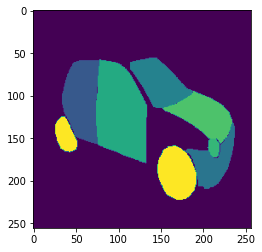

In [112]:
img,trg = val_set[0]
plt.imshow(val_set.unnorm(img).transpose(0,1).transpose(1,-1))
plt.show()
plt.imshow(trg.argmax(0))

In [114]:
#std = torch.zeros(3)
#mu = torch.zeros(3)
#for im,_ in trainLoader:
#    #mu.append(im.mean(dim=[0,2,3]).tolist())
#    #std.append(im.std(dim=[0,2,3]).tolist())
#    mu += im.mean(dim=[0,2,3])
#    std += im.std(dim=[0,2,3])
#mu = mu/len(trainLoader)
#std = std/len(trainLoader)

In [142]:
n_classes = 19
mod = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
for module in mod.modules():
    module.requires_grad = False
mod.aux_classifier = None

mod.classifier[-1] = nn.Conv2d(256, n_classes, kernel_size=(1, 1), stride=(1, 1))
diction = torch.load('Untitled Folder/transfer_b.pth')
diction = {i[len('module.'):]:diction[i] for i in diction}
mod.load_state_dict(diction)


<All keys matched successfully>

In [143]:
import wandb

#config = dict(
#              dataset_id = "kaggle_segmentation",
#              loss_fn = "dice with softmax",
#              batch_size = batch_size,
#              from_scratch = True)

wandb.init(
  project="car_segmentation",
  notes="Tranfer from del",
  tags=["other data",'added jitter','car_class'],
  #config=config,
    entity="jensp")
#wandb.init(project="car_segmentation", entity="jensp")

In [144]:
batch_size = 128
num_workers = 4
device = 'cuda'

opt = optim.Adam(mod.parameters())
trainLoader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                         drop_last=True,num_workers=num_workers)
valLoader = DataLoader(val_set, batch_size=batch_size, shuffle=False,
                         drop_last=False,num_workers=num_workers)
flag = True


In [145]:
for module in mod.modules():
    module.requires_grad = True

* Epoch 1/20


* Epoch 2/20


* Epoch 3/20


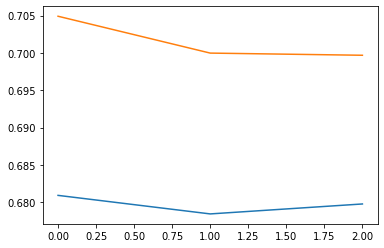

* Epoch 4/20


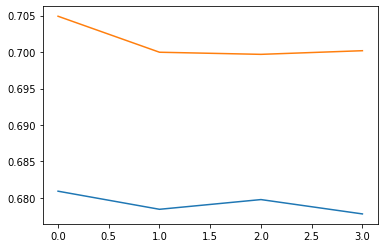

* Epoch 5/20


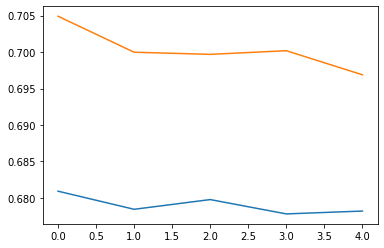

* Epoch 6/20


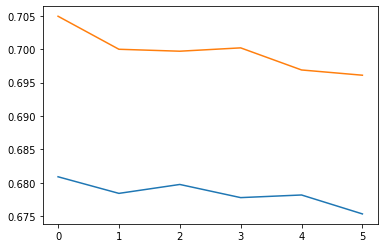

* Epoch 7/20


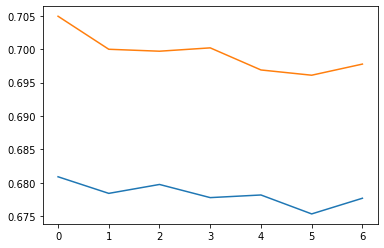

* Epoch 8/20


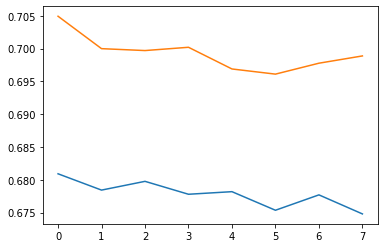

* Epoch 9/20


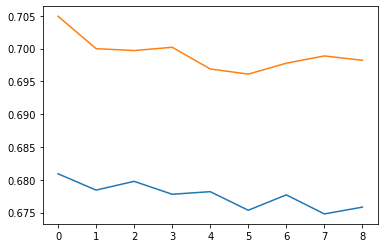

* Epoch 10/20


* Epoch 11/20


* Epoch 12/20


* Epoch 13/20


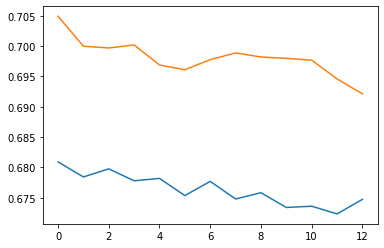

* Epoch 14/20


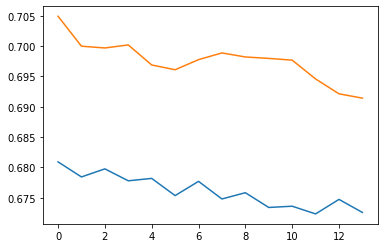

* Epoch 15/20


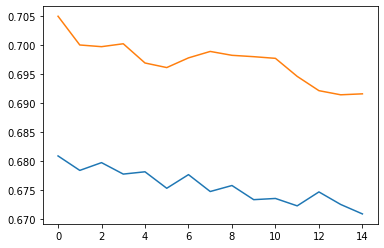

* Epoch 16/20


* Epoch 17/20


* Epoch 18/20


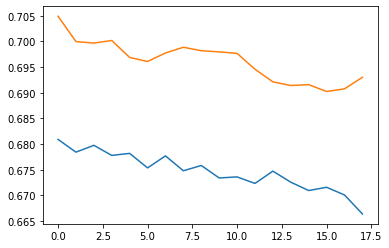

* Epoch 19/20


* Epoch 20/20


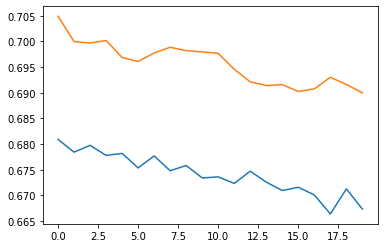

In [161]:
from monai.losses import DiceLoss,DiceCELoss,FocalLoss
MAX_POWER = True
epochs = 20
import matplotlib.pyplot as plt
device = 'cuda'
mod = mod.to(device)
lr = 1e-4
opt = optim.Adam(mod.parameters(),lr)
loss_fn = DiceLoss(softmax=True)

if torch.cuda.device_count() > 1 and MAX_POWER and flag:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    mod = nn.DataParallel(mod)
    flag = False

train_loss_lst = []
val_loss_lst = []
for epoch in range(epochs):
    print('* Epoch %d/%d' % (epoch+1, epochs))
    epoch_loss = 0
    val_loss = 0
    mod.train()  # train mode
    for b, (X_batch,Y_batch) in enumerate(trainLoader):
        # set parameter gradients to zero
        opt.zero_grad()

        # forward
        Y_pred = mod(X_batch.to(device))['out']
        #Y_batch = Y_batch.to(device).argmax(1)
        #Y_batch = torch.tensor(Y_batch, dtype=torch.long, device=device)
        loss = loss_fn(Y_pred, Y_batch.to(device)) 
        loss.backward()  # backward-pass
        opt.step()  # update weights

        # calculate metrics to show the user
        epoch_loss += loss.detach().item()
        #if ((b) % 2) == 0:
        #    print(b,"batch loss = ", loss)
            
    mod.eval()
    with torch.no_grad():  # inference mode
        for X_batch,Y_batch in valLoader:
            Y_pred = mod(X_batch.to(device))['out']
            val_loss += loss_fn(Y_pred, Y_batch.to(device)).detach().item()
    
    val_loss = val_loss/(len(valLoader))    #*val_batch_sz)
    epoch_loss = epoch_loss/(len(trainLoader))
    
    train_loss_lst.append(epoch_loss)
    val_loss_lst.append(val_loss)
    #print('Validation loss',val_loss)
    #print('Trainging loss', epoch_loss)
    plt.plot(train_loss_lst)
    plt.plot(val_loss_lst)
    plt.show()
    wandb.log({"epoch_loss": epoch_loss,
              "val_loss": val_loss})

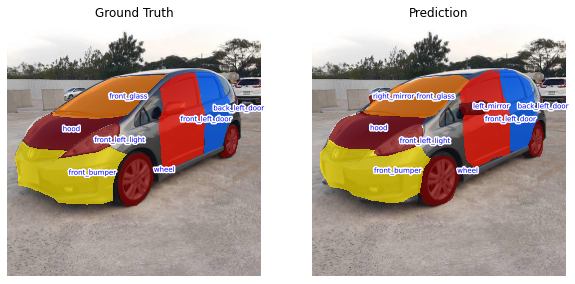

In [158]:
device = 'cpu'
mod.eval()

i = 14
mod = mod.cuda()
img, mask = val_set[i]
img = img.cuda()
out = mod(img.unsqueeze(0))['out'][0].cpu().detach()


plot_eval(train_set.unnorm(img.cpu()),mask,out,classes,(10,10),7,norm=False,bg=0)

In [154]:
n_classes = 19
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[-1] = nn.Conv2d(256, 19, kernel_size=(1, 1), stride=(1, 1))
model.aux_classifier = None
diction = torch.load('Untitled Folder/transfer_b.pth')
diction = {i[len('module.'):]:diction[i] for i in diction}
model.load_state_dict(diction)
model = model.to(device)

In [162]:
device = 'cuda'
mod = mod.to(device)
mod.eval()
val_loss = 0
with torch.no_grad():
    for X_batch,Y_batch in valLoader:
        Y_pred = mod(X_batch.to(device))['out']
        #val_loss = metric(Y_pred, Y_batch.to(device)).detach().item()
        y_pred = (Y_pred.softmax(axis=1) >= 1/9)
        gt = (Y_batch.to(device) == 1)
        TP = (gt&y_pred).sum(axis=0).sum(-1).sum(-1)
        denom = gt.sum(axis=0).sum(-1).sum(-1) + y_pred.sum(axis=0).sum(-1).sum(-1)
        denom_alt = 2 * TP + (~gt&y_pred).sum(axis=0).sum(-1).sum(-1) + (gt&~y_pred).sum(axis=0).sum(-1).sum(-1)
        #TP = (gt*y_pred).sum(axis=0).sum(-1).sum(-1)
        #denom = gt.sum(axis=0).sum(-1).sum(-1) + y_pred.sum(axis=0).sum(-1).sum(-1)
        
        
        preds = Y_pred.softmax(axis=1).argmax(1).view(-1)
        ground = Y_batch.argmax(1).view(-1)
        
        acc = torch.sum(preds == ground.to(device))/len(preds)
        dice = torch.mean(2*TP/denom)
        miou = torch.mean(TP/(TP+(~gt&y_pred).sum(axis=0).sum(-1).sum(-1)+(gt&~y_pred).sum(axis=0).sum(-1).sum(-1)))
        
        #wandb.log({"dice": dice,
        #           "acc": acc})